In [1]:
import matplotlib
# matplotlib.use("Agg")

In [2]:
from ok.mask import LivenessNet
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
import time

In [3]:
INIT_LR = 1e-4
BS = 8
EPOCHS = 50

In [4]:
print("[INFO] loading images...")
dataset =  ("../dataset-ori/")
imagePaths = list(paths.list_images(dataset))
data = []
labels = []

[INFO] loading images...


In [5]:
# loop over all image paths
for imagePath in imagePaths:
	# extract the class label from the filename, load the image and
	# resize it to be a fixed 32x32 pixels, ignoring aspect ratio
	label = imagePath.split(os.path.sep)[-2]
	image = cv2.imread(imagePath)
	image = cv2.resize(image, (32, 32))

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

In [6]:
# convert the data into a NumPy array, then preprocess it by scaling
# all pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0

In [7]:
# encode the labels (which are currently strings) as integers and then
# one-hot encode them
le = LabelEncoder()
labels = le.fit_transform(labels)
labels = to_categorical(labels, 2)

In [8]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.25, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
	horizontal_flip=True, fill_mode="nearest")

In [9]:
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model = LivenessNet.build(width=32, height=32, depth=3,
	classes=len(le.classes_))
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


/Users/dsisains/Documents/Projects/Current/ekyc-2022/liveness-res/color/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2022-01-20 15:33:17.263121: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# train the network
print("[INFO] training network for {} epochs...".format(EPOCHS))
seconds = time.time()
H = model.fit(x=aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS, epochs=EPOCHS)

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(x=testX, batch_size=BS)
report = (classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=le.classes_))
print(report)
# print(classification_report(testY.argmax(axis=1),
# 	predictions.argmax(axis=1), target_names=le.classes_))
# save the network to disk
model_path =  "../res/model/liveness.model" #specify path
print("[INFO] serializing network to '{}'...".format(model_path))
model.save(model_path, save_format="h5")
# save the label encoder to disk
f = open("../res/model/le.pickle", "wb")  #specify directory
f.write(pickle.dumps(le))
f.close()
print("total time for training =", seconds)	

[INFO] training network for 50 epochs...
Epoch 1/50
554/554 [==============================] - 13s 22ms/step - loss: 0.8990 - accuracy: 0.5831 - val_loss: 0.4219 - val_accuracy: 0.9115
Epoch 2/50
554/554 [==============================] - 12s 21ms/step - loss: 0.7047 - accuracy: 0.6932 - val_loss: 0.4022 - val_accuracy: 0.9257
Epoch 3/50
554/554 [==============================] - 11s 19ms/step - loss: 0.5695 - accuracy: 0.7754 - val_loss: 0.3706 - val_accuracy: 0.9358
Epoch 4/50
554/554 [==============================] - 10s 18ms/step - loss: 0.4672 - accuracy: 0.8460 - val_loss: 0.2979 - val_accuracy: 0.9466
Epoch 5/50
554/554 [==============================] - 10s 18ms/step - loss: 0.3885 - accuracy: 0.8858 - val_loss: 0.2506 - val_accuracy: 0.9446
Epoch 6/50
554/554 [==============================] - 10s 18ms/step - loss: 0.3172 - accuracy: 0.9169 - val_loss: 0.2059 - val_accuracy: 0.9534
Epoch 7/50
554/554 [==============================] - 10s 17ms/step - loss: 0.2724 - accuracy: 

In [11]:
# plot the training loss and accuracy
# plot = str('../res/model/plot.png')
# plt.style.use("ggplot")
# plt.figure()
# plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
# plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
# plt.plot(np.arange(0, EPOCHS), H.history["accuracy"], label="train_acc")
# plt.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label="val_acc")
# plt.title("Training Loss and Accuracy on Dataset")
# plt.xlabel("Epoch #")
# plt.ylabel("Loss/Accuracy")
# plt.legend(loc="lower left")
# plt.savefig(plot)

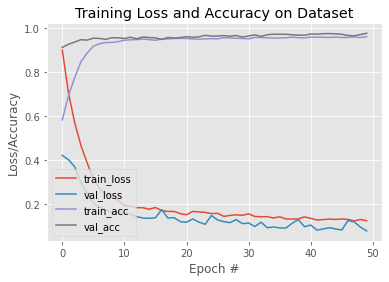

In [12]:
# plot the training loss and accuracy -- in notebook
# plot = str('../res/model/plot.png')
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
# plt.savefig(plot)